#Lab 3
##Graham Roberts
###8 January 2016

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import integrate as intgrt
import math
%matplotlib inline

In [2]:
class dataFrame326(object):
# dataFrame326
# This is a class that I built for this class
# It holds a set of measurements and their uncertainties
# Most functions have the keyward argument (kwarg)delta which means that you want to deal with the uncertainties
# Usually this is only useful if you're curious about the distribution of uncertainty estimates
# It also holds a couple of functions that output useful information on the class
# In python anything preceded by __ (two underscores) should be treated as a method or attribute private to the object
# additionally ther self argument seen in these function's signatures is automattically passed without any manual reference


    def __calcAverage(self, **kwargs):
        #calcAverage
        #this function takes no arguments except the delta kwarg
        #If the delta flag is true the average of the uncertainties is calculated
        #Normally simply returns the average of the measurements array
       if ('delta' in kwargs) and kwargs['delta']==True:
            return np.sum(self.__uncertainties)/len(self.__uncertainties)
       else:
            return np.sum(self.__measurements)/len(self.__measurements)
    
    def __calcSD(self, **kwargs):
        #calcSD
        #This function calculates the standard deviation
        #if delta is true the standard deviation of the uncertainties is returned
        meanSquared, denominator = 1,1
        if ('delta' in kwargs) and kwargs['delta']==True:
             meanSquared=np.sum([(i-self.__delta_av)**2 for i in self.__uncertainties])
             denominator=len(self.__uncertainties)-1
        else:
            meanSquared=np.sum([(i-self.__av)**2 for i in self.__measurements])
            denominator=len(self.__measurements)-1
        return np.sqrt(meanSquared/denominator)
    
    def __calcWAV(self):
        #calcWAV this returns the weighted average, and uncertainty of the weighted average
        #There is no weighted average of uncertainties 
       weights=np.zeros(len(self.__measurements))
       for i in range (0,len(self.__measurements)):
          if self.__uncertainties[i]!=0:
             weights[i]=1./(self.__uncertainties[i])**2
          else:
             weights[i]=1./((self.__sd)**2)
       return float(np.sum(self.__measurements*weights))/np.sum(weights), 1./np.sqrt(np.sum(weights))
   

    def __init__(self, measurements, uncertainties):
        #Constructor 
        #called as varname = dataFrame326(measurements,uncertainties)
        #populates the private arrays containing the measurements and uncertainties
        #calculates and stores the hidden attributes av[average], sd, min, max, and wav
        #for the measurements and uncertainties axcept the wav
        self.__measurements=measurements
        self.__uncertainties=uncertainties
        self.__av=self.__calcAverage()
        self.__delta_av=self.__calcAverage(delta=True)
        self.__sd=self.__calcSD()
        self.__delta_sd=self.__calcSD(delta=True)
        self.__wav=self.__calcWAV()
        self.__min=min(measurements)
        self.__delta_min=min(uncertainties)
        self.__max=max(measurements)
        self.__delta_max=max(uncertainties)
        
    def mean(self, **kwargs):
        #mean
        #this is a getter for the value of mean
        #this returns the mean of measurements or uncertainties
        if('delta' in kwargs) and kwargs['delta']==True:
            return self.__delta_av
        else:
                    return self.__av
            
    def sd(self, **kwargs):
        #this is a getter for standard deviation
       if ('delta' in kwargs) and kwargs['delta'] ==True:
          return self.__delta_sd
       else:
                    return self.__sd
        
        
    def wav(self):
        #getter for weighted average
        return self.__wav[0], self.__wav[1]
    
    def min(self,**kwargs):
        #min overloads the max function
        #if called in the manner varname.max() the maximum of the measurements in varname is returned
        if ('delta' in kwargs) and kwargs['delta'] ==True:
            return self.__delta_min
        else:
            return self.__min
        
    def max(self,**kwargs):
        #getter overloads the max function
        if ('delta' in kwargs) and kwargs['delta'] ==True:
            return self.__delta_max
        else:
            return self.__max
    
    def retrieve(self, **kwargs):
        #retrieve 
        #returns the array of measurements or uncertainties
        #additional kwarg sd
        #is sd is True only the values within 1 sd of the mean are returned
        if ('delta' in kwargs) and kwargs['delta'] ==True:
            values = self.__uncertainties
            d=True
        else:
            values = self.__measurements
            d=False
        if ('sd' in kwargs) and kwargs['sd'] ==True:
            values=values[np.where(np.logical_and(values>=self.mean(delta=d)-self.sd(delta=d),values<=self.mean(delta=d)+self.sd(delta=d)))]
        return values
            
    def Gaussian(self, **kwargs):
        #Gaussian
        #returns two arrays,
        #the first is an array of x-values used to calculate the gaussian
        #the second is their corresponding y-values
        #perfect for plotting
        #if delta is True a gaussian of uncertainties is returned
        #useful for pure academic curiosity
        #if sd is True only the values within 1 sd are returned
        #useful for integration
       if ('delta' in kwargs) and kwargs['delta']==True:
          sequence=np.linspace(int(self.__delta_min-1),int(self.__delta_max+1),1000)
          if ('sd' in kwargs) and kwargs['sd']==True:
                sequence=sequence[np.where(np.logical_and(sequence<=self.__delta_av+self.__delta_sd, sequence>=self.__delta_av-self.__delta_sd))]
          normalizationFactor=1./(np.sqrt(2.*np.pi)*self.__delta_sd)
          exponent=(-((sequence-self.__delta_av)**2)/(2.*self.__delta_sd**2))
       else:
          sequence=np.linspace(int(self.__min-1),int(self.__max+1),1000)
          if ('sd' in kwargs) and kwargs['sd']==True:
               sequence=sequence[np.where(np.logical_and(sequence<=self.__av+self.__sd, sequence>=self.__av-self.__sd))]
          normalizationFactor=1./(np.sqrt(2.*np.pi)*self.__sd)
          exponent=(-((sequence-self.__av)**2)/(2.*(self.__sd**2))) 
       Gauss = normalizationFactor*np.exp(exponent)
       return sequence, Gauss
   
    def calcBreaks(self, **kwargs):
        #calcbreaks
        #returns an array of bins for a histogram
        #one is centered on the mean, and they have bin widths of 1 sd
       upper=[]
       lower=[]
       if ('delta' in kwargs) and kwargs['delta']==True:
           values=self.__uncertainties
           sd=self.__delta_sd
           mean=self.__delta_av
           min=self.__delta_min
           max=self.__delta_max
       else:
           values=self.__measurements
           sd=self.__sd
           mean=self.__av
           min=self.__min
           max=self.__max
       upper.append(mean+sd/2.)
       lower.append(mean-sd/2.)
       i=mean+sd/2.
       while i < max:
           j=i+sd
           upper=upper+[j]
           i=j  
       i=mean-sd/2.
       while i > min:
           j=i-sd
           lower=lower+[j]
           i=j
       lower=list(reversed(lower))
       return np.array(lower+upper)
    

In [3]:
#This cell simply construct diameter and mass dataFrames from the text files
diameter, diameterDelta = np.loadtxt("diameter.txt",skiprows=1,unpack=True)
m, massDelta = np.loadtxt("mass.txt",skiprows=1,unpack=True)
diameter = dataFrame326(diameter, diameterDelta)
mass = dataFrame326(m,massDelta)

the area under the top histogram is 35.9993951074
The mean is 53.5259701493
the standard deviation is 0.558130156704
the weighted average is 53.641897287 with uncertainty 0.00092817718694
the area under the Gaussian is approximately 0.995866780336 and should be 1
the area under the Gaussian in one standard deviation is 0.680447144146 and should be .68
the percentage of values actually in within one standard deviation is 65


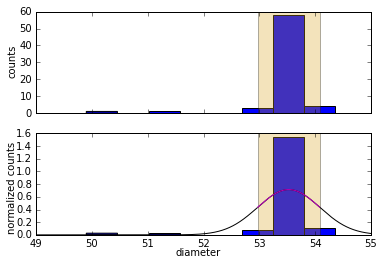

In [4]:
#This cell creates two matplotlib subplots for diameter
#The top is simply a histogram
#The bottom is a normalized histogram with a superimposed Gaussian
#Additionally the statistics you requested are provided and annotated
f, axarr = plt.subplots(2,1,sharex='col')
hist= axarr[0].hist(diameter.retrieve(),bins=diameter.calcBreaks(),normed=False)
plt.text(48.66,2.75,'counts',ha='right',va='center',rotation='vertical')
axarr[1].hist(diameter.retrieve(),bins=diameter.calcBreaks(),normed=True)
plt.text(48.66,0.75,'normalized counts',ha='right',va='center',rotation='vertical')
plt.text(51.5,-0.33,'diameter')
x,y=diameter.Gaussian()
xprime,yprime=diameter.Gaussian(sd=True)
axarr[1].plot(x,y,'black')
axarr[1].plot(xprime,yprime,'m')
axarr[1].axvspan(diameter.mean()-diameter.sd(),diameter.mean()+diameter.sd(),facecolor='goldenrod',alpha=0.3)
axarr[0].axvspan(diameter.mean()-diameter.sd(),diameter.mean()+diameter.sd(),facecolor='goldenrod',alpha=0.3)
in1sd=np.where(np.logical_and(x>=diameter.mean()-diameter.sd(), x<=diameter.mean()+diameter.sd()))
print 'the area under the top histogram is '+str(np.trapz(hist[0],dx=np.diff(diameter.calcBreaks())[0]))
print 'The mean is '+str(diameter.mean())
print 'the standard deviation is '+str(diameter.sd())
print 'the weighted average is '+str(diameter.wav()[0])+' with uncertainty '+str(diameter.wav()[1])
print 'the area under the Gaussian is approximately ' +str(np.trapz(y,x))+' and should be 1'
print 'the area under the Gaussian in one standard deviation is '+str(np.trapz(yprime,xprime))+' and should be .68'
print 'the percentage of values actually in within one standard deviation is ' + str(len((diameter.retrieve(sd=True))/len(diameter.retrieve())))

the area under the top histogram is 12.785746028
The mean is 1.34014925373
the standard deviation is 0.193723424667
the weighted average is 1.42115387873 with uncertainty 0.00342442326047
the area under the Gaussian is approximately 0.999999999998 and should be 1
the area under the Gaussian in one standard deviation is 0.678835276132 and should be .68
the percentage of values actually in within one standard deviation is 43


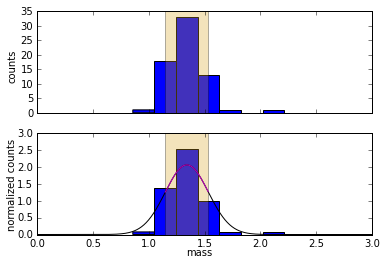

In [5]:
#This is very similar to the cell above except for mass not diameter
f, axarr = plt.subplots(2,1,sharex='col')
hist =axarr[0].hist(mass.retrieve(),bins=mass.calcBreaks(),normed=False)
plt.text(-.18,5,'counts',ha='right',va='center',rotation='vertical')
axarr[1].hist(mass.retrieve(),bins=mass.calcBreaks(),normed=True)
plt.text(-.18,1.5,'normalized counts',ha='right',va='center',rotation='vertical')
plt.text(1.33,-0.6,'mass')
x,y=mass.Gaussian()
xprime,yprime=mass.Gaussian(sd=True)
axarr[1].plot(x,y,'black')
axarr[1].plot(xprime,yprime,'m')
axarr[1].axvspan(mass.mean()-mass.sd(),mass.mean()+mass.sd(),facecolor='goldenrod',alpha=0.3)
axarr[0].axvspan(mass.mean()-mass.sd(),mass.mean()+mass.sd(),facecolor='goldenrod',alpha=0.3)
in1sd=np.where(np.logical_and(x>=mass.mean()-mass.sd(), x<=mass.mean()+mass.sd()))
print 'the area under the top histogram is '+str(np.trapz(hist[0],dx=np.diff(mass.calcBreaks())[0]))
print 'The mean is '+str(mass.mean())
print 'the standard deviation is '+str(mass.sd())
print 'the weighted average is '+str(mass.wav()[0])+' with uncertainty '+str(mass.wav()[1])
print 'the area under the Gaussian is approximately ' +str(np.trapz(y,x))+' and should be 1'
print 'the area under the Gaussian in one standard deviation is '+str(np.trapz(yprime,xprime))+' and should be .68'
print 'the percentage of values actually in within one standard deviation is ' + str(len((mass.retrieve(sd=True))/len(mass.retrieve())))
